# Описание кейса
> К нам обратился клиент, который занимается сборкой и продажей персональных компьютеров (за исключением мини-ПК и моноблоков). В связи с ростом популярности интернет-магазинов, таких как Wildberries, Ozon, OnlineTrade и т. п., за последние несколько лет, а также с целью привлечения большего числа клиентов при одновременном снижении затрат на содержание собственного магазина, доставку и рекламу товаров он планирует выйти на онлайн-рынок. В связи с этим клиент хотел бы узнать, от чего зависит цена, а также популярность персональных компьютеров, выкладываемых на онлайн-площадках, чтобы в дальнейшем планировать к сборке востребованные по техническим характеристикам компьютеры и продавать их по конкурентной цене.

Специалистом по сбору данных был выгружен файл в формате csv с одного из популярных онлайн-магазинов, содержащий информацию о товарах категории «Компьютеры и моноблоки».

Проанализируйте полученные данные и представьте аналитический отчет, содержащий выводы и рекомендации для Заказчика, которые помогут ему для решения своих бизнес-задач.

# **Предобработка данных**

## 0. Импорт библиотек и подгрузка файла

In [3]:
# from google.colab import files
import pandas as pd
import numpy as np
import json
import re
from matplotlib import pyplot as plt
import scipy
import scipy.stats as stats
import seaborn as sns
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as lm

In [19]:
df = pd.read_csv('data_marketplace/df_3.csv')

## 1.	Обзор файла и описание проблем

In [20]:
df.head()

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,Операционная система,Гарантийный срок,Страна производства,clean_price,clean_feedbacks
0,10148385,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10805₽,Купили более 400 раз,7 отзывов,0.0,"{'Процессор_тип': 'Intel Celeron', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics,отсутствует,3года,Россия,10805,7
1,17877962,Системный блок,32900₽,0,0 отзывов,0.0,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,Китай,32900,0
2,17880420,Компьютер Hp Prodesk 400 g6 mt,35720₽,0,0 отзывов,0.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,не указано,35720,0
3,19347937,Офисный Компьютер Robotcomp Казначей V1,39237₽,Купили более 10 раз,1 отзыв,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel UHD Graphics 630,windows пробная,3 Года (36 месяцев),Россия,39237,1
4,19348951,Игровой Компьютер Robotcomp М16 2.0 V1,76188₽,Купили более 200 раз,94 отзыва,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,windows пробная,3 Года (36 месяцев),Россия,76188,94


**В первую очередь определим целевые переменные.**

После визуального обзора данных можно сказать, что у нас 2 целевые переменные: **'price' и 'sales'**.

---------------------

Также считаю, что полезно увидеть несколько случайных наблюдений из датасета.
Это иногда помогает увидеть особенности датасета уже на этапе визуального обзора: например, наличие ошибок, пропусков в данных.

In [15]:
df.sample(10)

,title,price_rur,sales,seller_rating,CPU,cores,RAM,size_of_RAM_GB,size_of_HDD_GB,size_of_SSD_GB,Видеопроцессор,Операционная система,Страна производства,Гарантийный срок(мес.),counts,counts_2
566,Офисный компьютер Xeon Themis A4 (E5-2640V3/16...,44619,NaN,4.6,Intel Xeon,8.0,DDR 4,16.0,NaN,240-256,NVIDIA GeForce GT 730,windows 10 pro,Россия,NaN,2976,1732
2436,Игровой компьютер ElitePC Golden 3 i5-10400F 1...,62414,NaN,4.8,Intel Core i5,6.0,DDR 4,16.0,NaN,960-1024,NVIDIA GeForce GTX 1660,windows 10 pro,Россия,12.0,2976,1732
2868,Игровой компьютер Astronaut M1 White,132880,NaN,0.0,Intel Core i7,8.0,DDR 4,32.0,NaN,960-1024,NVIDIA GeForce RTX 3070,windows 11 pro,NaN,NaN,2976,659
2849,Игровой компьютер Slasher M2 White,88880,NaN,0.0,Intel Core i7,8.0,DDR 4,16.0,NaN,960-1024,NVIDIA GeForce RTX 3060,windows 11 pro,NaN,NaN,2976,659
460,Игровой Компьютер Robotcomp Star V1 Power,30853,30.0,4.7,AMD Athlon,2.0,DDR 4,16.0,NaN,240-256,AMD Radeon Vega 3,windows trial,Россия,36.0,2976,297
2126,Игровой компьютер B-Dusk 3,91002,NaN,4.7,Intel Core i7,8.0,DDR 4,32.0,1000.0,480-512,NVIDIA GeForce RTX 3060,windows 10 pro,NaN,NaN,2976,1732
1158,Игровой компьютер Roo24 i7-12700F/3080 10Gb,157965,NaN,4.7,Intel Core i7,6.0,DDR 4,32.0,1000.0,480-512,NVIDIA GeForce RTX 3080,windows 10 pro,Россия,36.0,2976,1732
684,"Компьютер, Системный Блок, ПК Intel i7",22074,NaN,4.1,Intel Core i7,8.0,DDR 3,8.0,500.0,120-128,Intel HD Graphics 2000,windows 10,Россия,12.0,307,428
3330,Игровой компьютер Combat M5,83790,NaN,0.0,Intel Core i5,6.0,DDR 4,16.0,NaN,960-1024,NVIDIA GeForce RTX 3060,windows 11 pro,NaN,NaN,2976,659
2876,Игровой компьютер Adventure M3 White,62656,NaN,0.0,Intel Core i5,6.0,DDR 4,16.0,NaN,960-1024,NVIDIA GeForce GTX 1650,windows 11 pro,NaN,NaN,2976,659


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3524 entries, 0 to 3523
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3524 non-null   object 
 1   price_rur               3524 non-null   int64  
 2   sales                   852 non-null    float64
 3   seller_rating           3524 non-null   float64
 4   CPU                     3285 non-null   object 
 5   cores                   3362 non-null   float64
 6   RAM                     3524 non-null   object 
 7   size_of_RAM_GB          3369 non-null   float64
 8   size_of_HDD_GB          1091 non-null   float64
 9   size_of_SSD_GB          3322 non-null   object 
 10  Видеопроцессор          3524 non-null   object 
 11  Операционная система    3524 non-null   object 
 12  Страна производства     1944 non-null   object 
 13  Гарантийный срок(мес.)  2170 non-null   float64
 14  counts                  3524 non-null   

**Итоги "описание проблем":**

1. Наличие признаков, не представляющих ценности в рамках кейса (габариты, product_id и др.).
2. Наличие значений признака "наименование товара" (title), не представляющих интереса для Заказчика (все, что не относится к персональным компьютерам).
3. Возможно наличие дубликатов.
4. Наличие незаполненных значений в признаках:

* Количество продаж товара (sales)
* Наименование продавца (seller)
* Рейтинг продавца (seller_rating)
* Видеопроцессор
* Операционная система
* Гарантийный срок
* Страна производства

5. Наличие вложенных значений (словарей по признакам 'Процессор', 'Оперативная память', 'Жесткий диск')
6. Необходимо приведение признаков в необходимый для исследования формат
8. Возможные другие проблемы, которые могут быть выявлены в процессе предобработки данных

## 2.	Выбор признаков для анализа
*Перед* проведением манипуляций создаю копию исходного датасета в отдельную переменную.

In [11]:
df_copy = df.copy()
df_copy.columns

Index(['product_id', 'title', 'price', 'sales', 'feedbacks', 'seller_rating',
       'Процессор', 'Оперативная память', 'Жесткий диск', 'Видеопроцессор',
       'Операционная система', 'Гарантийный срок', 'Страна производства',
       'clean_price', 'clean_feedbacks'],
      dtype='object')


Из всех представленных признаков товара явно не интересными для исследования являются признак**и 'Габариты товар**а' **и 'Габариты товара (с упаковкой**)'. Их буду удалять из датасета.

Во-первых, само понятие "персональный компьютер", может включать как только один системный блок, так и полный комплект, состоящий, например, из системного блока, монитора и клавиатуры. То есть рассмотреть отдельно хотя бы габариты системного блока в каждом отдельном случае не удастся, из-за того, что в большой части наблюдений представлены комплекты с габаритами, вероятно, всего комплекта.

Во-вторых, полагаю, что даже если есть отдельные покупатели, которые ищут системный блок с определенной глубиной или высотой, то таких покупателей будет очень немного, чтобы всерьез рассматривать этот параметр, как значимый для исследования.

Габариты упаковки тем более на выбор товара покупателем практически не влияют.

Также принято решение удали ' колонку 'feedbacks', так как в наборе данных нет информации о том, какие отзывы, положительные или отрицательные, что может противоречиво влиять на целевые показатели.

In [ ]:
df_copy['seller'].unique()

При просмотре уникальных значений признака 'seller' не обнаружено каких-то популярных магазинов электроники, которые могли бы влиять на желание покупателя сделать выбор в пользу товара, опираясь на извстность магазина.
По этой причине параметр **'seller'** также удаляю.

In [ ]:
columns = ['feedbacks','seller','Габариты товара','Габариты товара (с упаковкой)']
df_copy.drop(columns=columns, inplace=True)

Также колонку **'product_id'** можно будет удалить перед началом разведочного и статистического анализа. На текущем этапе она нужна для идентификации товара на сайте wildberries.ru, откуда и был получен датасет.

**Итоги:**

1. Из датасета было удалено 4 ненужные для анализа колонки: 'feedbacks','seller','Габариты товара','Габариты товара (с упаковкой)'.
2. Также непосредственно перед началом исследования будет удалена колонка 'product_id', которая также не несет интереса для аналитического исследования, но на этапе предобработки возможно понадобится аналитику.

## 3. Проверка на дубликаты, их обработка

In [ ]:
df_copy.duplicated().sum()

In [ ]:
df_copy.shape

In [ ]:
df_copy.drop_duplicates(inplace=True)
df_copy.shape

In [ ]:
df_copy.reset_index(drop=True, inplace=True)
df_copy.index

**Итоги**: 

в результате проверки было обнаружено **490 полных дубликатов**. Наличие полностью дублирующих наблюдений будут мешать качеству ислледования, поэтому полные дубликаты были удалены из датасета, значения индексов были перезаписаны для удобства работы с получившимся набором данных.

## 4. Проверка данных на пропущенные значения, их обработка или исключение.

In [ ]:
df_copy.isna().sum()

In [ ]:
df_copy.isnull().mean()*100

In [ ]:
df_copy.dropna(subset=['price'], inplace=True)
df_copy['seller_rating'].fillna('0.0', inplace=True)
df_copy

In [ ]:
df_copy.reset_index(drop=True, inplace=True)
df_copy.index

**Итоги**:
1. **'price'** - цена товара. Встретилось только 1 одно наблюдение из 4500, в котором пропущена цена (целевой показатель), принято решение  этим наблюдением с пропущенной ценой перенебречь. Поэтому это наблюдение из датасета было удалено.
2. **'sales'** - округленное количество продаж товара. Обнаружено почти 74% пропущенных значений в этом признаке. Восстановить их нет возможности. Разумным решением в отношении этой целевой переменной было бы провести отдельное исследование только по тем товарам, где поле 'sales' заполнено.
2. **'seller_rating'** - рейтинг продавца. Пропущенных значений всего 2,4%. В рамках кейса можно принять пропущенное значение рейтинга за нулевой рейтинг. Пропущенные значения заменили на 0.0.
3. **'Гарантийный срок'** - пропущенных значений 41%, что достаточно велико. Пропущенные значения оставили без обработки.
4. **'Страна производства'** - пропущенных значений 42%, что достаточно велико. Пропущенные значения оставили без обработки.

## 5.	Проверка типов данных, приведение данных в необходимый тип

In [ ]:
df_copy.dtypes

**Необходимо преобразовать** следующие признаки:
1. 'price' - в формат целого числа int
2. 'feedbacks' - в формат целого числа int
3. 'sales' - в формат целого числа int
4. 'Гарантийный срок' - в формат, удобный для работы с признаком (определим при более детальном осмотре)

### 'price'

In [ ]:
df_copy['price']

In [ ]:
def clear_price(price):
  return int(re.sub('₽', '', price))

In [ ]:
df_copy['clean_price'] = df_copy['price'].apply(clear_price)
df_copy.head()

In [ ]:
df_copy.drop(columns='price', inplace=True)
df_copy.rename(columns={'clean_price': 'price_rur'}, inplace=True)
df_copy.info()

### 'sales'

In [ ]:
df_copy['sales'].unique()

В наборе данных есть значения "менее 5 раз", "более 5 раз", "более 10 раз", чтобы привести эти значения к числовым, нам необходимо в разных числовых эквивалентах обозначить "менее 5 раз" и "более 5 раз".

Все, где написано "более N раз" будем обозначать числом N, а "менее 5 раз" обозначим как 2.

In [ ]:
df_copy.loc[df_copy['sales']=='Купили менее 5 раз', 'sales'] = 'Купили менее 2 раз'
df_copy['sales'].value_counts()

In [ ]:
df_copy['sales'][0].split(' ')[2]

In [ ]:
def sales_func(sales):
  if pd.isna(sales):
    result = np.nan
  else:
    result = sales.split(' ')[2]
  return result

In [ ]:
df_copy['sales'] = df_copy['sales'].apply(sales_func)
df_copy['sales']

In [ ]:
df_copy['sales'].unique()

In [ ]:
df_copy.index[df_copy['sales']=='5\xa0200'].tolist()

Наблюдение со значением '5\xa0200' в колонке 'sales всего одно, удалим его, чтобы можно было изменить тип данных во всей колонке.

In [ ]:
df_copy = df_copy.drop(index=714)
df_copy['sales'].unique()

In [ ]:
df_copy['sales'] = df_copy['sales'].astype('Int64')
df_copy.info()

### 'seller_rating'

In [ ]:
df_copy['seller_rating'] = df_copy['seller_rating'].astype('float')

### 'Гарантийный срок'

In [24]:
df_copy['Гарантийный срок'].unique()

array(['3года', nan, '3 Года (36 месяцев)', '6 мес.', '6 мес', '3 года',
       '36 мес', '1 (один) год', '36 месяцев', '12 месяцев,', '24 мес',
       '12 месяцев', '12 мес', '1 год', '7 дней', '1 год ( 12 месяцев )',
       '3 мес', '30 дней', '24 месяца', '12 мес.', '2 года', '6 месяцев',
       '36 мес.', '12', '3 месяца', '1', '14 дней', '365; дней',
       '1 год; 12 мес', '1 год; 12 месяцев', '1 месяц', '2 месяца',
       '12 месяцев от King Komp', '12 месяцев от KING KOMP',
       '1 год (12 месяцев)'], dtype=object)

In [25]:
df_copy['Гарантийный срок'].value_counts()

Гарантийный срок
3 Года (36 месяцев)        767
1 год                      750
3 года                     460
12 месяцев                 142
36 месяцев                  47
36 мес.                     39
12 месяцев от KING KOMP     30
24 месяца                   27
2 года                      19
1 год; 12 мес               12
1 (один) год                12
6 мес                        9
1 год; 12 месяцев            7
12 мес                       5
3 месяца                     5
6 месяцев                    5
12 месяцев от King Komp      4
1 год (12 месяцев)           4
7 дней                       3
12 мес.                      2
24 мес                       2
6 мес.                       2
30 дней                      1
3 мес                        1
1 год ( 12 месяцев )         1
12                           1
1                            1
14 дней                      1
365; дней                    1
12 месяцев,                  1
1 месяц                      1
2 месяца              

Формат написания данных очень разный, поэтому будет удобнее впоследствии данные из этой категории заменить и закодировать.

**Итоги:**

1. Значения переменной **'price'** приведены к виду int, сама переменная переименована в 'price_rur', что позволит понять в дальнейшем, в какой валюте цена на товары.
2. Значения переменной **'sales**' приведены к типу Int64, в признаке остались пропущенные значения. Удалено одно наблюдение с ошибкой в данных. Также стоит обратить внимание, что значение этой колонки необходимо читать как "купили более N раз", где N - значение переменной. А все значения 'Купили менее 5 раз' приведены к значению '2', чтобы не путать их со значениями 'Купили более 5 раз', которое приведено к значению '5'.
3. Значения переменной '**Гарантийный срок**' будут позже заменены или закодированы для дальнейшего анализа, вследствии их разнопланового формата заполнения.

## 6. Фильтрация наблюдений от товаров, не представляющих ценности в рамках кейса.

Сначала удалим лишние наблюдения, которые явно не относятся к компьютерам. Компьютеры (даже если это один системный блок) не может стоить меньше 8 000 рублей, поэтому уберем все товары стоимостью меньше 8 000 рублей.

! Путем нескольких итераций фильтрации датасета по цене и последующего просмотра результатов, была выбрана сумма 10 000 рублей в качестве критического значения для фильтрации.

In [ ]:
filter_by_price = df_copy['price_rur']>10000
filtred_df_1 = df_copy[filter_by_price]
filtred_df_1

In [ ]:
sorted_df_1 = filtred_df_1.sort_values('price_rur')
sorted_df_1.head(12)

В результате видно, что в датасете все равно присутствуют лишние товары, не имеющие ценности для исследования.
Поэтому стоит провести фильтрацию по колонке 'title', и сохранить только те товары, в которых есть следующие фразы: 'компьютер', 'Компьютер', 'системный блок', 'Системный блок', 'ПК'.

* При визуальном обзоре было замечено, что существуют персональные компьютеры в датасете, у которых нет в поле 'title' упомянутых выше слов. В рамках исследования придется ими пренебречь.

In [ ]:
names = ['компьютер','Компьютер','системный блок','Системный блок','ПК']
filtred_df_2 = filtred_df_1[filtred_df_1['title'].str.contains('|'.join(names), regex=True)]
filtred_df_2

In [ ]:
sorted_df_2 = filtred_df_2.sort_values('price_rur')
sorted_df_2.head(12)

Согласно кейсу исключим из датасета товары "Мини ПК" и "Моноблоки", а также некоторые товары, которые попали в датасет, но не имеют ценности для Заказчика.

In [ ]:
names = ['Мини','мини','Моноблок','моноблок','Мыш','мыш','Микро','микро','POS','Pos','pos']
filtred_df_3 = filtred_df_2[~(filtred_df_2['title'].str.contains('|'.join(names), regex=True))]
filtred_df_3

In [ ]:
sorted_df_3 = filtred_df_3.sort_values('price_rur')
sorted_df_3.head(15)

In [ ]:
filtred_df_3.reset_index(drop=True, inplace=True)

In [ ]:
filtred_df_3.index

In [ ]:
df_3 = filtred_df_3.copy()

**Итоги:**

В результате фильтрации из предоставленного датасета были удалены:
* Мини ПК и микрокопьютеры
* Моноблоки
* Комплектующие и другие товары, которые попали в эту выборку случайно.

Датасет скоратился с 4009 наблюдений до 3524.

Также после осуществления фильтрации были обновлены индексы датасета для большего удобства работы с набором данных.

In [165]:
df_3 = pd.read_csv('data_marketplace/filtred_df_3_18.07_2.csv')

## 7.	Распаковка данных

Необходимо распаковать данные в следующих призниаках: **'Процессор', 'Оперативная память', 'Жесткий диск'**

### 'Процессор'

In [166]:
df_3['Процессор']

0       {'Процессор_тип': 'Intel Celeron', 'Количество...
1       {'Процессор_тип': 'Intel Core i5', 'Количество...
2       {'Процессор_тип': 'не заполнено', 'Количество ...
3       {'Процессор_тип': 'Intel Core i5', 'Количество...
4       {'Процессор_тип': 'Intel Core i5', 'Количество...
                              ...                        
3519    {'Процессор_тип': 'Intel Core i5', 'Количество...
3520    {'Процессор_тип': 'Intel Core i5', 'Количество...
3521    {'Процессор_тип': 'Intel Core i5', 'Количество...
3522    {'Процессор_тип': 'Intel Core i5', 'Количество...
3523    {'Процессор_тип': 'Intel Core i5', 'Количество...
Name: Процессор, Length: 3524, dtype: object

In [167]:
df_3['Процессор'][1340]

"{'Процессор_тип': 'AMD Ryzen 6', 'Количество ядер процессора': '6'}"

In [168]:
df_3['Процессор'][15]

"{'Процессор_тип': 'Intel Core i5', 'Количество ядер процессора': '6'}"

In [169]:
json.loads(df_3['Процессор'][15].replace("'", '"'))

{'Процессор_тип': 'Intel Core i5', 'Количество ядер процессора': '6'}

In [170]:
json.loads(df_3['Процессор'][15].replace("'", '"'))['Процессор_тип']

'Intel Core i5'

In [171]:
json.loads(df_3['Процессор'][15].replace("'", '"'))['Количество ядер процессора']

'6'

In [172]:
def text_to_CPU(text):
  result = json.loads(text.replace("'", '"'))['Процессор_тип']
  return result

def text_to_cores(text):
  result = json.loads(text.replace("'", '"'))['Количество ядер процессора']
  return result

In [173]:
df_3['CPU'] = df_3['Процессор'].apply(text_to_CPU)
df_3['CPU']

0       Intel Celeron
1       Intel Core i5
2        не заполнено
3       Intel Core i5
4       Intel Core i5
            ...      
3519    Intel Core i5
3520    Intel Core i5
3521    Intel Core i5
3522    Intel Core i5
3523    Intel Core i5
Name: CPU, Length: 3524, dtype: object

In [174]:
df_3['CPU'].isna().sum()

0

In [175]:
df_3['CPU'].value_counts()

CPU
Intel Core i5                           1115
Intel Core i7                            691
Intel Core i3                            490
AMD Ryzen 5                              483
не заполнено                             238
AMD Athlon                               121
Intel Xeon                                73
AMD Ryzen 7                               71
AMD Ryzen 3                               51
AMD A6                                    45
Intel Pentium                             38
Intel E5                                  22
Intel Core i9                             13
Intel E3                                  11
Intеl Quad                                11
Intel Celeron                              6
AMD Ryzen 9                                5
AMD A12-9800E                              4
Intel                                      3
Intel Core 12400F                          3
Q9400                                      3
AMD Ryzen 6                                2
AMD Ra

In [176]:
df_3['cores'] = df_3['Процессор'].apply(text_to_cores)
df_3['cores']

0                  2
1       не заполнено
2       не заполнено
3                  6
4                  6
            ...     
3519               6
3520               6
3521               6
3522               6
3523               6
Name: cores, Length: 3524, dtype: object

In [177]:
df_3['cores'].value_counts()

cores
6               1413
4                611
8                356
12               284
2                250
не заполнено     162
4 ядра           132
10               128
8 ядер            66
24 ядра           60
16                46
14                 7
20                 7
2 ядра             1
6 ядер             1
Name: count, dtype: int64

In [178]:
df_3['cores'].isna().sum()

0

In [179]:
df_3['cores'].sample(18)

2206               6
1992               8
1685               6
617                6
2778               8
296                2
3349               6
2301              10
3501               8
1851               6
1202          4 ядра
3146         24 ядра
2596               8
2284              12
1810               6
862     не заполнено
3034               8
1940               6
Name: cores, dtype: object

In [180]:
def clear_cores(cores):
  if cores == 'не заполнено':
    result = np.nan
  else:
    result = int(re.sub('\D', '', cores))
  return result

In [181]:
df_3['clean_cores'] = df_3['cores'].apply(clear_cores)
df_3['clean_cores'].unique()

array([ 2., nan,  6., 10.,  4., 12., 16.,  8., 14., 20., 24.])

In [182]:
df_3['clean_cores'] = df_3['clean_cores'].astype('Int64')

In [183]:
df_3['clean_cores'].isna().sum()

162

In [184]:
df_3['clean_cores'].dtypes

Int64Dtype()

### 'Оперативная память'

In [185]:
df_3['Оперативная память']

0       {'Тип оперативной памяти': 'DDR 3', 'Объем опе...
1       {'Тип оперативной памяти': 'не заполнено', 'Об...
2       {'Тип оперативной памяти': 'не заполнено', 'Об...
3       {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
4       {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
                              ...                        
3519    {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
3520    {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
3521    {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
3522    {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
3523    {'Тип оперативной памяти': 'DDR 4', 'Объем опе...
Name: Оперативная память, Length: 3524, dtype: object

In [186]:
df_3['Оперативная память'][77]

"{'Тип оперативной памяти': 'DDR 4', 'Объем оперативной памяти (Гб)': '16 ГБ'}"

In [187]:
eval(df_3['Оперативная память'][77].replace("'", '"'))['Тип оперативной памяти']

'DDR 4'

In [188]:
df_3['RAM'] = df_3['Оперативная память'].apply(lambda x: eval(x)['Тип оперативной памяти'])
df_3['RAM'].value_counts()

RAM
DDR 4           2976
DDR 3            307
не заполнено     223
DDR 5             14
16                 2
16 Гб              1
RAM 16 ГБ          1
Name: count, dtype: int64

In [189]:
df_3[df_3['RAM'].str.contains('16')]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,Операционная система,Гарантийный срок,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM
2556,147211674,"Игровой компьютер /16GB/SSD-512/Монитор-24""",68800₽,0,0 отзывов,4.5,"{'Процессор_тип': 'Intel E5', 'Количество ядер...","{'Тип оперативной памяти': '16', 'Объем операт...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce RTX 1060,Windows 11 Pro,1 год,Россия,68800,0,Intel E5,12,12,16
2558,147213987,"Игровой компьютер /16GB/SSD-512/Монитор-24""",69120₽,0,0 отзывов,4.5,"{'Процессор_тип': 'Intel Xeon', 'Количество яд...","{'Тип оперативной памяти': '16 Гб', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce RTX 1060,Windows 11 Pro,1 год,Россия,69120,0,Intel Xeon,12,12,16 Гб
2657,149811385,Системный блок ReaL-PC Gaming V2 (Intel Core i...,50250₽,0,0 отзывов,3.9,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'RAM 16 ГБ', 'Объем...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,Windows 10,2 месяца,Китай,50250,0,Intel Core i5,6,6,RAM 16 ГБ
2803,150787428,Игровой компьютер,51300₽,0,0 отзывов,5.0,"{'Процессор_тип': 'AMD Ryzen 5', 'Количество я...","{'Тип оперативной памяти': '16', 'Объем операт...","{'Объем накопителя HDD': None, 'Объем накопите...",AMD Radeon Vega 7,Windows 10,1 год,Россия,51300,0,AMD Ryzen 5,6,6,16


Обнаружено 4 значения с ошибкой в данных, заменяю их значениями "не заполнено", которые уже встречаются в столбце.

In [190]:
def clear_RAM(ram):
  if ram == '16':
    result = 'не заполнено'
  elif ram == '16 Гб':
    result = 'не заполнено'
  elif ram == 'RAM 16 ГБ':
    result = 'не заполнено'
  elif pd.isna(ram):
    result = 'np.nan'
  else:
    result = ram
  return result

In [191]:
df_3['RAM'] = df_3['RAM'].apply(clear_RAM)
df_3['RAM'].unique()

array(['DDR 3', 'не заполнено', 'DDR 4', 'DDR 5'], dtype=object)

In [192]:
df_3['RAM'].isna().sum()

0

In [193]:
df_3['size_of_RAM_GB'] = df_3['Оперативная память'].apply(lambda x: eval(x)['Объем оперативной памяти (Гб)'])
df_3['size_of_RAM_GB'].unique()

array(['4 ГБ', '16 ГБ', '8', '16', '32', '6 ГБ', None, '32 ГБ', '8 ГБ',
       '16 гб', '4', '64', '8 GB', '240 гб', '8 Гб', '64 ГБ', '32 гб',
       '16ГБ', '8 гб', '16 gb', '16 Гб', '4 GB', '1000 гб', '64 гб',
       '16 Gb', '4 гб'], dtype=object)

In [194]:
df_3['size_of_RAM_GB'].isna().sum()

155

In [195]:
def clear_sizeRAM(text):
  if pd.isna(text):
    result = np.nan
  else:
    result = re.sub('\D', '', text)
  return result

In [196]:
df_3['size_of_RAM_GB'] = df_3['size_of_RAM_GB'].apply(clear_sizeRAM)
df_3['size_of_RAM_GB'].unique()

array(['4', '16', '8', '32', '6', nan, '64', '240', '1000'], dtype=object)

In [197]:
df_3['size_of_RAM_GB'] = df_3['size_of_RAM_GB'].astype('Int64')

In [198]:
df_3[df_3['size_of_RAM_GB'].isna()]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,Операционная система,Гарантийный срок,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB
81,43110911,Компьютер,10965₽,0,0 отзывов,3.4,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,США,10965,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
152,50843197,Настольный компьютер Chip computers Medium5. П...,27022₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,Россия,27022,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
153,51188117,Настольный компьютер Chip computers Medium10. ...,32091₽,Купили менее 5 раз,1 отзыв,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,Россия,32091,1,не заполнено,не заполнено,<NA>,не заполнено,<NA>
157,51246035,Настольный компьютер Chip computers Basic5,16128₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,Россия,16128,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
161,51397251,Настольный компьютер Chip computers Medium4. П...,27746₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,Россия,27746,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206,151706240,Системный Ryzen 5 2600 компьютер игровой,70000₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,не указано,70000,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
3207,151706241,Системный Ryzen 5 2600 компьютер игровой,69300₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,не указано,69300,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
3208,151706242,Системный Ryzen 5 2600 компьютер игровой,82500₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,не указано,82500,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>
3209,151706244,Системный Ryzen 5 2600 компьютер игровой,46200₽,0,0 отзывов,5.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,отсутствует,0,не указано,46200,0,не заполнено,не заполнено,<NA>,не заполнено,<NA>


In [199]:
df_RAM = df_3[df_3['size_of_RAM_GB'].isna()]

In [200]:
df_3 = df_3[~(df_3['size_of_RAM_GB'].isna())]
df_3[df_3['size_of_RAM_GB'].isna()]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,Операционная система,Гарантийный срок,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB


После визуального осмотра данных, где параметр 'size_of_RAM_GB' имеет пропущенное значение выяснилось, что практически все технические характеристики этих товаров не заполнены или уже приведены к нулю. В связи с этим принято решение удалить эти наблюдения из датасета.

### 'Жесткий диск'

In [201]:
df_3['Жесткий диск']

0       {'Объем накопителя HDD': None, 'Объем накопите...
1       {'Объем накопителя HDD': None, 'Объем накопите...
2       {'Объем накопителя HDD': None, 'Объем накопите...
3       {'Объем накопителя HDD': None, 'Объем накопите...
4       {'Объем накопителя HDD': None, 'Объем накопите...
                              ...                        
3519    {'Объем накопителя HDD': '1000 гб', 'Объем нак...
3520    {'Объем накопителя HDD': '1000 Гб', 'Объем нак...
3521    {'Объем накопителя HDD': '1000 Гб', 'Объем нак...
3522    {'Объем накопителя HDD': '1000 гб', 'Объем нак...
3523    {'Объем накопителя HDD': '1000 гб', 'Объем нак...
Name: Жесткий диск, Length: 3369, dtype: object

In [202]:
df_3['Жесткий диск'][3520]

"{'Объем накопителя HDD': '1000 Гб', 'Объем накопителя SSD': '500 Гб'}"

In [203]:
eval(df_3['Жесткий диск'][3520].replace("'", '"'))['Объем накопителя HDD']

'1000 Гб'

In [204]:
df_3['size_of_HDD'] = df_3['Жесткий диск'].apply(lambda x: eval(x)['Объем накопителя HDD'])
df_3['size_of_HDD'].value_counts()

size_of_HDD
1000 Гб          641
1000 Gb          102
500 Gb            73
1000              70
1 Тб              66
нет               33
1000 гб           23
2000 Гб           21
1Tb               20
500 Гб            20
1 тб              16
512 Гб             8
нет; без HDD       7
1024 ГБ            5
500 гб             4
1 TB               4
2TB                4
500                3
250 гб             2
Отсутствует        2
2 тб               2
отсутствует        1
2 ТБ               1
без HDD            1
256 Гб             1
4000 Гб; 4000      1
1000GB             1
500; 500 гб        1
2000Gb             1
3000 гб            1
Name: count, dtype: int64

In [205]:
df_3['size_of_HDD'].isna().sum()
df_3['size_of_HDD'].isnull().mean()*100

66.31047788661324

В столбце 'size_of_HDD' обнаружилось 67% пропущенных значений, обрабатывать их нельзя, иначе это может повлять на резуьтаты работы критериев позже, при анализе. Оставляем пока, как есть.

In [206]:
df_3['size_of_SSD'] = df_3['Жесткий диск'].apply(lambda x: eval(x)['Объем накопителя SSD'])
df_3['size_of_SSD'].unique()

array([None, '256 Гб', '512 Гб', '480 ГБ', '960 Гб', '2 Тб', '240 Гб',
       '1000GB PCI-E', '128 Гб', '480Gb', '240Gb', '120 ГБ', '256Gb',
       '120GB', '120', '512Gb', '500GB', '960Gb', '512', '128', '256',
       '1000gb', '16 Гб', '480 GB', '120 GB', '240 GB',
       '512Гб арт. 100343717', '1000 Гб', '1024 гб', '256 гб', '512 гб',
       '250 ГБ', '480', '500 Гб', '1240 гб', '1480 гб', '1000 гб', '1 Тб',
       '512 GB', '480 гб', '2000', '480 Gb', '120 Gb', '240 Gb',
       '2000 гб', '1024 Гб', '1 тб', '240', '512 ГБ M.2 PCIe', '2000 ГБ',
       '256 Gb SSD', '512Гб', '256 Gb', '1000', '512Гб арт. 143553804',
       '1000 GB', '60 gb', '240 гб', '500 гб', '250 гб', '120 гб',
       '240; 240 гб', '250', '128; 128 гб', '500', '1500 Гб', '2 тб',
       '512 Gb', '480; 960', '1500 гб', '1500', '256 гб; 960 гб',
       '256 Гб + 1 TB', '1000Гб арт. 152611584'], dtype=object)

In [207]:
df_3[df_3['size_of_SSD'].str.contains('арт.', na=False)]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
790,100343717,Игровой Компьютер NAGIBATOR AMD RYZEN 5 4600G ...,35940₽,Купили более 200 раз,117 отзывов,4.9,{'Процессор_тип': 'AMD RYZEN 4600g Vega7 арт. ...,"{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",AMD Radeon Vega 7,...,Россия,35940,117,AMD RYZEN 4600g Vega7 арт. 100343717,6,6,DDR 4,16,None,512Гб арт. 100343717
1837,143553804,Игровой Компьютер NAGIBATOR AMD RYZEN 5 4600G ...,35940₽,Купили более 10 раз,117 отзывов,4.9,{'Процессор_тип': 'AMD RYZEN 4600g Vega7 арт. ...,"{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",AMD Radeon Vega 7,...,Россия,35940,117,AMD RYZEN 4600g Vega7 арт. 143553804,6,6,DDR 4,16,None,512Гб арт. 143553804
3500,152611584,Игровой Компьютер NAGIBATOR AMD RYZEN 5 5600G ...,41930₽,0,117 отзывов,4.9,"{'Процессор_тип': 'AMD Ryzen 5', 'Количество я...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",AMD Radeon Vega 8,...,Россия,41930,117,AMD Ryzen 5,6,6,DDR 4,16,None,1000Гб арт. 152611584


In [210]:
df_3['size_of_SSD'][790] = df_3['size_of_SSD'][790].split(' ')[0]
df_3['size_of_SSD'][1837] = df_3['size_of_SSD'][1837].split(' ')[0]
df_3['size_of_SSD'][3500] = df_3['size_of_SSD'][3500].split(' ')[0]

C:\Users\imaru\AppData\Local\Temp\ipykernel_7992\1778178029.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['size_of_SSD'][790] = df_3['size_of_SSD'][790].split(' ')[0]
C:\Users\imaru\AppData\Local\Temp\ipykernel_7992\1778178029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3['size_of_SSD'][1837] = df_3['size_of_SSD'][1837].split(' ')[0]
C:\Users\imaru\AppData\Local\Temp\ipykernel_7992\1778178029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [211]:
df_3[df_3['size_of_SSD'].str.contains('арт.', na=False)]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD


In [212]:
df_3['size_of_SSD'].isna().sum()

48

In [213]:
df_3['size_of_SSD'].unique()

array([None, '256 Гб', '512 Гб', '480 ГБ', '960 Гб', '2 Тб', '240 Гб',
       '1000GB PCI-E', '128 Гб', '480Gb', '240Gb', '120 ГБ', '256Gb',
       '120GB', '120', '512Gb', '500GB', '960Gb', '512', '128', '256',
       '1000gb', '16 Гб', '480 GB', '120 GB', '240 GB', '512Гб',
       '1000 Гб', '1024 гб', '256 гб', '512 гб', '250 ГБ', '480',
       '500 Гб', '1240 гб', '1480 гб', '1000 гб', '1 Тб', '512 GB',
       '480 гб', '2000', '480 Gb', '120 Gb', '240 Gb', '2000 гб',
       '1024 Гб', '1 тб', '240', '512 ГБ M.2 PCIe', '2000 ГБ',
       '256 Gb SSD', '256 Gb', '1000', '1000 GB', '60 gb', '240 гб',
       '500 гб', '250 гб', '120 гб', '240; 240 гб', '250', '128; 128 гб',
       '500', '1500 Гб', '2 тб', '512 Gb', '480; 960', '1500 гб', '1500',
       '256 гб; 960 гб', '256 Гб + 1 TB', '1000Гб'], dtype=object)

**Итоги:**

В результате распаковки данных в датасете появились новые колонки:

1. **CPU** - тип процессора, представлен типом данных object. Обнаружено 238 пропущенных значений, они помечены меткой "не заполнено".
2. **clean_cores** - количество ядер процессора, данные приведены к типу int64. Обнаружено 9 пропущенных значений.
3. **RAM** - тип оперативной памяти, представлен типом данных object. В этой колонке было обнаружено 4 ошибочных значения колонки, они были заменены на "не заполнено" (так как такая метка уже присутствует у некоторых товаров в этой колонке). Также в этой колонке обнаружено 223 пропущенных значений, они помечены меткой "не заполнено".
4. **size_of_RAM** - размер оперативной памяти, данные приведены к типу int64. Обнаружено 155 пропущенных значений. После визуального осмотра данных с пропущенными значениями выяснилось, что практически все технические характеристики этих товаров не заполнены или уже приведены к нулю, то есть эти наблюдения не интересны для исследования. В связи с этим принято решение удалить эти наблюдения из датасета.
5. **size_of_HDD** - объем накопителя HDD, данные представлены object. Рассчитываю преобразовать даные позже с помощью группировки или кодировки. Обнаружено 66% пропущенных значений, В столбце 'size_of_HDD' обнаружилось 66% пропущенных значений, это очень много, обрабатывать их не будем, чтобы не повлять на расчет критериев позже.
6. **size_of_SSD** - объем накопителя SSD, данные представлены object. Рассчитываю преобразовать даные позже с помощью группировки или кодировки. Обнаружено 48 пропущенных значений.

## 8. Обзор и замена значений

### 'Операционная система'

In [214]:
df_3['Операционная система'].value_counts()

Операционная система
Windows 10 Pro                                   1727
Windows 11 Pro                                    658
Windows 10                                        377
windows пробная                                   219
отсутствует                                       144
Windows 10 Home                                    44
Windows                                            36
Windows 11                                         34
Windows 10 Pro Trial                               29
Free DOS                                           27
Windows 10 пробная                                 23
windows 10 trial                                   19
Windows 11 Home                                     5
WINDOWS 10                                          4
Windows 10 pro                                      3
Windows 10 Home пробная                             3
windows 10                                          3
WINDOWS 11                                          3
Windows

In [215]:
df_3['Операционная система'] = df_3['Операционная система'].str.lower()
sorted(df_3['Операционная система'].unique())

['dos',
 'free dos',
 'microsoft windows 11',
 'widows 11 pro',
 'window 10 pro trial',
 'windows',
 'windows 10',
 'windows 10 home',
 'windows 10 home пробная',
 'windows 10 pro',
 'windows 10 pro trial',
 'windows 10 pro; office 2016 home and business',
 'windows 10 trial',
 'windows 10 пробная',
 'windows 11',
 'windows 11 home',
 'windows 11 pro',
 'windows 11 pro (trial)',
 'windows пробная',
 'windows пробная версия',
 'без oc',
 'отсутствует']

In [216]:
def os_func(value):
  if pd.isnull(value):
    return value
  elif 'dos' in value:
    return 'dos'
  elif 'trial' in value:
    return 'windows trial'
  elif '11' in value:
    return 'windows 11'
  elif '10' in value:
    return 'windows 10'
  elif 'пробная' in value:
    return 'windows trial'
  elif 'без' in value:
    return 'отсутствует'
  else:
    return value
  return result

In [217]:
df_3['Операционная система'] = df_3['Операционная система'].apply(os_func)
sorted(df_3['Операционная система'].unique())

['dos', 'windows', 'windows 10', 'windows 11', 'windows trial', 'отсутствует']

In [218]:
df_3['Операционная система'].value_counts()

Операционная система
windows 10       2186
windows 11        703
windows trial     271
отсутствует       145
windows            36
dos                28
Name: count, dtype: int64

### 'Гарантийный срок'
Приводим все значения гарантийного срока к количеству месяцев.


In [220]:
df_3['Гарантийный срок'].value_counts()

Гарантийный срок
0                          1203
3 Года (36 месяцев)         755
1 год                       640
3 года                      459
12 месяцев                  129
36 месяцев                   47
24 месяца                    27
12 месяцев от KING KOMP      26
36 мес.                      22
2 года                       19
1 год; 12 мес                12
1 год; 12 месяцев             7
1 год (12 месяцев)            4
6 месяцев                     3
24 мес                        2
3 месяца                      2
12 месяцев от King Komp       2
12 мес                        1
6 мес                         1
12                            1
1                             1
14 дней                       1
12 месяцев,                   1
36 мес                        1
2 месяца                      1
6 мес.                        1
3года                         1
Name: count, dtype: int64

In [221]:
df_3[df_3['Гарантийный срок']=='14 дней']

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
1389,142410611,Офисный компьютер Office one/i3-2120,17850₽,0,0 отзывов,4.0,"{'Процессор_тип': 'Intel Core i3', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics 2000,...,не указано,17850,0,Intel Core i3,2,2,DDR 3,8,None,256 гб


Найдено одно наблюдение, у которого срок гарантии 14 дней, округляем его до 1 месяца, чтобы можно было работать с данными типа int.

Можно было бы округлить до 0 месяцев, но, по моему мнению, гарантия 14 дней не равноценна гарантии 0 дней.

Именно поэтому это значение округлено до 1 месяца.

In [222]:
df_3['Гарантийный срок'] = df_3['Гарантийный срок'].str.lower()
df_3.loc[df_3['Гарантийный срок']=='14 дней', 'Гарантийный срок'] = '1 месяц'

In [223]:
df_3['Гарантийный срок'].value_counts()

Гарантийный срок
0                          1203
3 года (36 месяцев)         755
1 год                       640
3 года                      459
12 месяцев                  129
36 месяцев                   47
12 месяцев от king komp      28
24 месяца                    27
36 мес.                      22
2 года                       19
1 год; 12 мес                12
1 год; 12 месяцев             7
1 год (12 месяцев)            4
6 месяцев                     3
24 мес                        2
3 месяца                      2
12 мес                        1
6 мес                         1
12                            1
1                             1
1 месяц                       1
12 месяцев,                   1
36 мес                        1
2 месяца                      1
6 мес.                        1
3года                         1
Name: count, dtype: int64

In [224]:
def guarantee_func(value):
  if pd.isnull(value):
    return value
  elif value == '2 года':
    return '24'
  elif '3 года' in value:
    return '36'
  elif '1 год' in value:
    return '12'
  elif '3года' in value:
    return '36'
  else:
    return re.findall(r'\d+', value)[0]
  return result

In [225]:
df_3['Гарантийный срок'] = df_3['Гарантийный срок'].apply(guarantee_func)

In [226]:
df_3['Гарантийный срок'] = df_3['Гарантийный срок'].astype('Int64')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3369 entries, 0 to 3523
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            3369 non-null   int64  
 1   title                 3369 non-null   object 
 2   price                 3369 non-null   object 
 3   sales                 3369 non-null   object 
 4   feedbacks             3369 non-null   object 
 5   seller_rating         3369 non-null   float64
 6   Процессор             3369 non-null   object 
 7   Оперативная память    3369 non-null   object 
 8   Жесткий диск          3369 non-null   object 
 9   Видеопроцессор        3369 non-null   object 
 10  Операционная система  3369 non-null   object 
 11  Гарантийный срок      3369 non-null   Int64  
 12  Страна производства   3369 non-null   object 
 13  clean_price           3369 non-null   int64  
 14  clean_feedbacks       3369 non-null   int64  
 15  CPU                   3369

In [227]:
df_3['Гарантийный срок'].nunique()

8

### 'CPU' - тип процессора


In [228]:
sorted(df_3['CPU'].unique())

['12400f',
 '6010',
 '8 ядер',
 'A10-5800KRAM',
 'AMD A12-9800E',
 'AMD A6',
 'AMD Athlon',
 'AMD E1-6010',
 'AMD FX-4300',
 'AMD FX-6100',
 'AMD RYZEN 4600g Vega7 арт. 100343717',
 'AMD RYZEN 4600g Vega7 арт. 143553804',
 'AMD Radeon RX 570',
 'AMD Ryzen 3',
 'AMD Ryzen 5',
 'AMD Ryzen 6',
 'AMD Ryzen 7',
 'AMD Ryzen 9',
 'AMD рязань 5 4650',
 'AMD рязань 5 5600x',
 'Gemini Lake Refresh J4115',
 'Intel',
 'Intel 4 ядра',
 'Intel Celeron',
 'Intel Core 12400F',
 'Intel Core Quad 9400',
 'Intel Core i 5 10400f',
 'Intel Core i3',
 'Intel Core i5',
 'Intel Core i7',
 'Intel Core i9',
 'Intel E3',
 'Intel E5',
 'Intel N5105',
 'Intel Pentium',
 'Intel Xeon',
 'Intel core 12400F',
 'Intеl Quad',
 'Intеl Quad 9400',
 'Intеl Quad Q9400',
 'Q9400',
 'Ryzen; 3 1300x',
 'intel core i 3 10100f',
 'intel core i 5 10400f',
 'не заполнено']

In [229]:
df_3[df_3['CPU'].str.contains('12400f')]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
177,54598844,Игровой компьютер Roo24 i5 Banshee,77127₽,0,0 отзывов,4.7,"{'Процессор_тип': '12400f', 'Количество ядер п...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce RTX 3060,...,Россия,77127,0,12400f,6,6,DDR 4,16,None,240Gb


In [230]:
df_3[df_3['CPU'].str.contains('8 ядер')]

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
379,73254762,Компьютер для игр и учебы 8GB/SSD-512/Монитор-22',36675₽,Купили более 5 раз,4 отзыва,4.5,"{'Процессор_тип': '8 ядер', 'Количество ядер п...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA,...,Россия,36675,4,8 ядер,8,8,DDR 3,8,None,512 Гб


In [231]:
sorted(df_3['CPU'].unique())

['12400f',
 '6010',
 '8 ядер',
 'A10-5800KRAM',
 'AMD A12-9800E',
 'AMD A6',
 'AMD Athlon',
 'AMD E1-6010',
 'AMD FX-4300',
 'AMD FX-6100',
 'AMD RYZEN 4600g Vega7 арт. 100343717',
 'AMD RYZEN 4600g Vega7 арт. 143553804',
 'AMD Radeon RX 570',
 'AMD Ryzen 3',
 'AMD Ryzen 5',
 'AMD Ryzen 6',
 'AMD Ryzen 7',
 'AMD Ryzen 9',
 'AMD рязань 5 4650',
 'AMD рязань 5 5600x',
 'Gemini Lake Refresh J4115',
 'Intel',
 'Intel 4 ядра',
 'Intel Celeron',
 'Intel Core 12400F',
 'Intel Core Quad 9400',
 'Intel Core i 5 10400f',
 'Intel Core i3',
 'Intel Core i5',
 'Intel Core i7',
 'Intel Core i9',
 'Intel E3',
 'Intel E5',
 'Intel N5105',
 'Intel Pentium',
 'Intel Xeon',
 'Intel core 12400F',
 'Intеl Quad',
 'Intеl Quad 9400',
 'Intеl Quad Q9400',
 'Q9400',
 'Ryzen; 3 1300x',
 'intel core i 3 10100f',
 'intel core i 5 10400f',
 'не заполнено']

In [232]:
def cpu_func(value):
  if pd.isnull(value):
    return value
  elif value == '6010':
    return 'AMD E1-6010'
  elif '12400' in value:
    return 'Intel Core i5'
  elif value == '8 ядер':
    return np.nan
  elif value == 'A10-5800KRAM':
    return 'AMD A10-5800K'
  elif ('AMD RYZEN 4600g Vega7' in value) or ('AMD рязань 5' in value):
    return 'AMD Ryzen 5'
  elif value == 'Gemini Lake Refresh J4115':
    return 'Intel Celeron'
  elif value == 'Intel 4 ядра':
    return 'Intel'
  elif ('9400' in value) or ('Quad' in value):
    return 'Intеl Core Quad'
  elif '10400f' in value:
    return 'Intel Core i5'
  elif value == 'Ryzen; 3 1300x':
    return 'AMD Ryzen 3'
  elif value == 'intel core i 3 10100f':
    return 'Intel Core i3'
  elif value == 'intel core i 5 10400f':
    return 'Intel Core i5'
  elif value == 'не заполнено':
    return np.nan
  else:
    return value

In [233]:
df_3['CPU'] = df_3['CPU'].apply(cpu_func)

In [234]:
df_3['CPU'].unique()
df_3['CPU'].isna().sum()

85

<Axes: ylabel='CPU'>

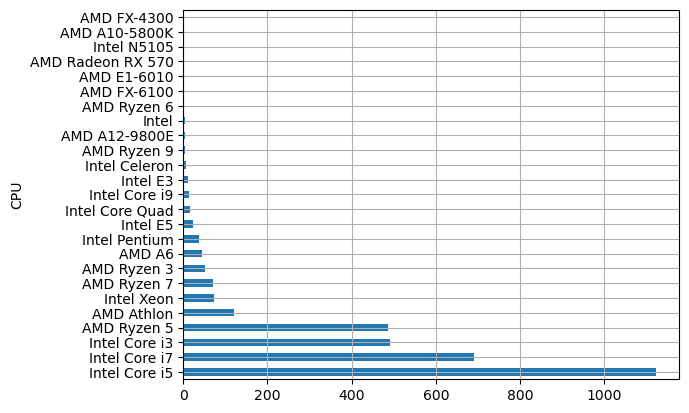

In [235]:
df_3['CPU'].value_counts().plot.barh(rot=0, grid=True)

In [236]:
df_3['CPU'].nunique()

25

### 'size_of_HDD'

Буду преобразовывать все значения в Гб.

In [237]:
df_3['size_of_HDD'].unique()

array([None, '1000 Гб', '2000 Гб', '1 Тб', '1 тб', '2000Gb', '1Tb', '500',
       'нет', '2TB', '1 TB', 'нет; без HDD', 'без HDD', '500 гб',
       '500 Gb', '1000 Gb', '3000 гб', '500 Гб', '1000', '2 ТБ', '512 Гб',
       'Отсутствует', 'отсутствует', '1000 гб', '250 гб', '256 Гб',
       '4000 Гб; 4000', '1000GB', '500; 500 гб', '1024 ГБ', '2 тб'],
      dtype=object)

In [238]:
df_3['size_of_HDD'] = df_3['size_of_HDD'].str.lower()
df_3['size_of_HDD'].isna().sum()

2234

In [239]:
def hdd_func(value):
  if pd.isnull(value):
    return np.nan
  elif (value == 'нет') or (value == 'без hdd') or (value == 'отсутствует') or (value == 'нет; без hdd'):
    return np.nan
  elif ('1000' in value) or ('1024' in value):
    return '1000'
  elif '2000' in value:
    return '2000'
  elif (value == '1 тб') or (value == '1tb') or (value == '1 tb'):
    return '1000'
  elif ('2tb' in value) or ('2 тб' in value):
    return '2000'
  elif ('500' in value) or ('512 гб' in value):
    return '500'
  elif '3000' in value:
    return '3000'
  elif '4000' in value:
    return '4000'
  elif ('250' in value) or ('256' in value):
    return '250'
  else:
    return np.nan

In [240]:
df_3['size_of_HDD'] = df_3['size_of_HDD'].apply(hdd_func)

In [241]:
df_3['size_of_HDD'].isna().sum()

2278

In [242]:
df_3['size_of_HDD'] = df_3['size_of_HDD'].astype('Int64')
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3369 entries, 0 to 3523
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            3369 non-null   int64  
 1   title                 3369 non-null   object 
 2   price                 3369 non-null   object 
 3   sales                 3369 non-null   object 
 4   feedbacks             3369 non-null   object 
 5   seller_rating         3369 non-null   float64
 6   Процессор             3369 non-null   object 
 7   Оперативная память    3369 non-null   object 
 8   Жесткий диск          3369 non-null   object 
 9   Видеопроцессор        3369 non-null   object 
 10  Операционная система  3369 non-null   object 
 11  Гарантийный срок      3369 non-null   Int64  
 12  Страна производства   3369 non-null   object 
 13  clean_price           3369 non-null   int64  
 14  clean_feedbacks       3369 non-null   int64  
 15  CPU                   3284

In [243]:
df_3['size_of_HDD'].value_counts()

size_of_HDD
1000    948
500     109
2000     29
250       3
3000      1
4000      1
Name: count, dtype: Int64

In [244]:
df_3['size_of_HDD'].nunique()

6

### 'size_of_SSD'

In [245]:
df_3['size_of_SSD'].unique()

array([None, '256 Гб', '512 Гб', '480 ГБ', '960 Гб', '2 Тб', '240 Гб',
       '1000GB PCI-E', '128 Гб', '480Gb', '240Gb', '120 ГБ', '256Gb',
       '120GB', '120', '512Gb', '500GB', '960Gb', '512', '128', '256',
       '1000gb', '16 Гб', '480 GB', '120 GB', '240 GB', '512Гб',
       '1000 Гб', '1024 гб', '256 гб', '512 гб', '250 ГБ', '480',
       '500 Гб', '1240 гб', '1480 гб', '1000 гб', '1 Тб', '512 GB',
       '480 гб', '2000', '480 Gb', '120 Gb', '240 Gb', '2000 гб',
       '1024 Гб', '1 тб', '240', '512 ГБ M.2 PCIe', '2000 ГБ',
       '256 Gb SSD', '256 Gb', '1000', '1000 GB', '60 gb', '240 гб',
       '500 гб', '250 гб', '120 гб', '240; 240 гб', '250', '128; 128 гб',
       '500', '1500 Гб', '2 тб', '512 Gb', '480; 960', '1500 гб', '1500',
       '256 гб; 960 гб', '256 Гб + 1 TB', '1000Гб'], dtype=object)

In [246]:
df_3['size_of_SSD'] = df_3['size_of_SSD'].str.lower()
df_3.loc[df_3['size_of_SSD'].str.contains('1000')|df_3['size_of_SSD'].str.contains('1024')|df_3['size_of_SSD'].str.contains('960')|df_3['size_of_SSD'].str.contains('1 тб'), 'size_of_SSD'] = '960-1024'
df_3.loc[df_3['size_of_SSD'].str.contains('500')|df_3['size_of_SSD'].str.contains('512')|df_3['size_of_SSD'].str.contains('480'), 'size_of_SSD'] = '480-512'
df_3.loc[df_3['size_of_SSD'].str.contains('256')|df_3['size_of_SSD'].str.contains('240')|df_3['size_of_SSD'].str.contains('250'), 'size_of_SSD'] = '240-256'
df_3.loc[df_3['size_of_SSD'].str.contains('128')|df_3['size_of_SSD'].str.contains('120'), 'size_of_SSD'] = '120-128'
df_3.loc[df_3['size_of_SSD'].str.contains('2000')|df_3['size_of_SSD'].str.contains('2 тб'), 'size_of_SSD'] = '200'
df_3.loc[df_3['size_of_SSD']=='16 гб', 'size_of_SSD'] = '16'
df_3.loc[df_3['size_of_SSD']=='60 gb', 'size_of_SSD'] = '60'

In [247]:
df_3['size_of_SSD'].unique()

array([None, '240-256', '480-512', '960-1024', '200', '120-128', '16',
       '60'], dtype=object)

In [248]:
df_3['size_of_SSD'].value_counts()

size_of_SSD
480-512     1550
960-1024     897
240-256      641
120-128      187
200           44
16             1
60             1
Name: count, dtype: int64

In [249]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3369 entries, 0 to 3523
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            3369 non-null   int64  
 1   title                 3369 non-null   object 
 2   price                 3369 non-null   object 
 3   sales                 3369 non-null   object 
 4   feedbacks             3369 non-null   object 
 5   seller_rating         3369 non-null   float64
 6   Процессор             3369 non-null   object 
 7   Оперативная память    3369 non-null   object 
 8   Жесткий диск          3369 non-null   object 
 9   Видеопроцессор        3369 non-null   object 
 10  Операционная система  3369 non-null   object 
 11  Гарантийный срок      3369 non-null   Int64  
 12  Страна производства   3369 non-null   object 
 13  clean_price           3369 non-null   int64  
 14  clean_feedbacks       3369 non-null   int64  
 15  CPU                   3284

In [250]:
df_3['size_of_SSD'].nunique()

7

### 'Видеопроцессор'

In [251]:
sorted(df_3['Видеопроцессор'].unique())

['AMD',
 'AMD Radeon R5',
 'AMD Radeon RX 470',
 'AMD Radeon RX 550',
 'AMD Radeon RX 570',
 'AMD Radeon RX 580',
 'AMD Radeon RX 6500',
 'AMD Radeon RX 6600',
 'AMD Radeon RX 6700',
 'AMD Radeon Vega 3',
 'AMD Radeon Vega 6',
 'AMD Radeon Vega 7',
 'AMD Radeon Vega 8',
 'Afox GeForce G210',
 'Intel HD Graphics',
 'Intel HD Graphics 2000',
 'Intel HD Graphics 2500',
 'Intel HD Graphics 4000',
 'Intel HD Graphics 530',
 'Intel HD Graphics 5770',
 'Intel HD Graphics 5850',
 'Intel HD Graphics 6000',
 'Intel HD Graphics 610',
 'Intel HD Graphics 630',
 'Intel UHD Graphics',
 'Intel UHD Graphics 600',
 'Intel UHD Graphics 605',
 'Intel UHD Graphics 610',
 'Intel UHD Graphics 630',
 'Intel UHD Graphics 730',
 'NVIDIA',
 'NVIDIA GeForce GT 1030',
 'NVIDIA GeForce GT 610',
 'NVIDIA GeForce GT 730',
 'NVIDIA GeForce GT 740',
 'NVIDIA GeForce GTX 1050',
 'NVIDIA GeForce GTX 1060',
 'NVIDIA GeForce GTX 1630',
 'NVIDIA GeForce GTX 1650',
 'NVIDIA GeForce GTX 1660',
 'NVIDIA GeForce GTX 550',
 'NV

In [252]:
df_3['Видеопроцессор'].value_counts()

Видеопроцессор
NVIDIA GeForce RTX 3060    594
NVIDIA GeForce RTX 3050    453
NVIDIA GeForce GTX 1650    322
NVIDIA GeForce GTX 1660    271
AMD Radeon Vega 7          212
                          ... 
Radeon R7 350                1
Afox GeForce G210            1
AMD Radeon Vega 6            1
RX 460                       1
NVIDIA GeForce GTX 970       1
Name: count, Length: 72, dtype: int64

In [253]:
df_3['Видеопроцессор'].value_counts()

Видеопроцессор
NVIDIA GeForce RTX 3060    594
NVIDIA GeForce RTX 3050    453
NVIDIA GeForce GTX 1650    322
NVIDIA GeForce GTX 1660    271
AMD Radeon Vega 7          212
                          ... 
Radeon R7 350                1
Afox GeForce G210            1
AMD Radeon Vega 6            1
RX 460                       1
NVIDIA GeForce GTX 970       1
Name: count, Length: 72, dtype: int64

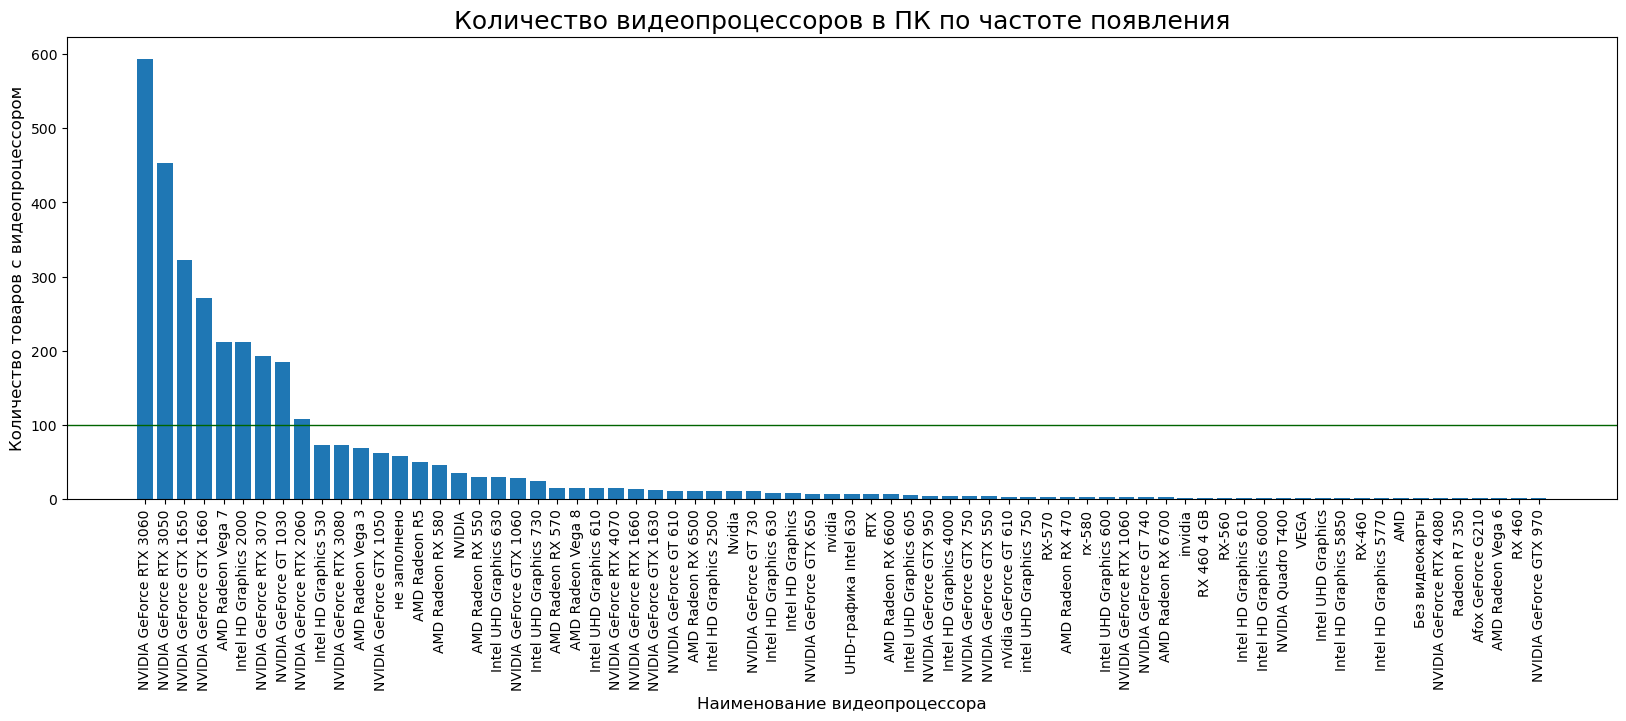

In [254]:
video_processor = df_3['Видеопроцессор'].value_counts()
fig = plt.figure(figsize = (20, 6))
plt.bar(video_processor.index, video_processor)

plt.title(label = "Количество видеопроцессоров в ПК по частоте появления", fontsize = 18)
plt.xlabel( "Наименование видеопроцессора", size = 12)
plt.ylabel("Количество товаров с видеопроцессором",  fontsize = 12)
plt.xticks(fontsize = 10, rotation = 90)

plt.axhline( y=100, color = 'darkgreen', linewidth=1)
#plt.text(x=65, y=110,  s='100 вакансий', size=11, color='black')

plt.show()

In [255]:
df_3['Видеопроцессор'].nunique()

72

**Итоги:**

1. '**Операционная система**' - набор значений в признаке почищен и приведен к 6 уникальным значениям.
2. '**Гарантийный срок**' - все значения в этом признаке были приведены к количеству месяцев. Также одно значение признака - 14 дней - было округлено до 1 месяца.
Благодаря этому количество уникальных значений признака приведено к 7.
Обнаружено 1354 пропущенных значений.
3. '**CPU**' - количество уникальных значений приведено к 25, это достаточно много, но группировать их я не вижу смысла, так как каждая модель процессора отличается своими характеристиками, и если группировать их по названию производителя или даже названию серии процессора, вероятнее всего никакого разумного результата получить не получится. Думаю, в данном случае можно будет провести исследование только по ТОПу наличия конкетной модели в ПК (персональных компьютерах) из имющегося датасета.
Обнаружено 239 пропущенных значений.
4. '**size_of_HDD_GB**' - все значения в этом признаке были приведены к объему в Гб. Некруглые значения признака типа "256, 512, 1024" приведены к круглым "250, 500, 1000" соответственно. По информации, полученной из открытого источника, это один и тот же обьем, но его часто пишут по разному (например, где-то пишется 1000, а где-то 1024, хотя объем по факту один и тот же).
Количество уникальных значений признака приведено к 6.
Обнаружено 2433 пропущенных значений (69%).
5. '**size_of_SSD**' -  все значения в этом признаке были приведены к объему в Гб. Также в этом признаке значения были сгруппированы в близкие по значению. Например, 240, 250 и 256 объединены в группу "240-256". Такое решение было принято в связи с тем, что в открытых источниках, касающихся обзоров комплектующих ПК близкие по объему твердотельные накопители (SSD) также группируются. К тому же такая группировка будет более удобной для исследования. Всего уникальных значений, уже сгруппированных, получилось 8.
Обнаружено 202 пропущенных значений.
6. '**Видеопроцессор**' - после чистки названий значений этого признака уникальных получилось 61 штука. Это очень много. Группировать здесь не считаю правильным, потому что (как и в случае с признаком 'CPU') среди моделей есть явные лидеры по популярности. Поэтому также будет произведено исследование только по ТОПу упомнинания их среди представленных ПК в датасете.

## 9. Кодирование признаков

In [257]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3369 entries, 0 to 3523
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            3369 non-null   int64  
 1   title                 3369 non-null   object 
 2   price                 3369 non-null   object 
 3   sales                 3369 non-null   object 
 4   feedbacks             3369 non-null   object 
 5   seller_rating         3369 non-null   float64
 6   Процессор             3369 non-null   object 
 7   Оперативная память    3369 non-null   object 
 8   Жесткий диск          3369 non-null   object 
 9   Видеопроцессор        3369 non-null   object 
 10  Операционная система  3369 non-null   object 
 11  Гарантийный срок      3369 non-null   Int64  
 12  Страна производства   3369 non-null   object 
 13  clean_price           3369 non-null   int64  
 14  clean_feedbacks       3369 non-null   int64  
 15  CPU                   3284

#### 'RAM'

In [259]:
df_3['RAM'].value_counts()

RAM
DDR 4           2972
DDR 3            307
не заполнено      76
DDR 5             14
Name: count, dtype: int64

In [260]:
dict_ram = {
    "DDR 3": 0,
    "DDR 4": 1,
    "DDR 5": 2,
    }

In [261]:
df_3 = df_3.replace(dict_ram)

In [262]:
df_3.head()

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
0,10148385,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10805₽,Купили более 400 раз,7 отзывов,0.0,"{'Процессор_тип': 'Intel Celeron', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics,...,Россия,10805,7,Intel Celeron,2,2,0,4,<NA>,None
1,17877962,Системный блок,32900₽,0,0 отзывов,0.0,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,Китай,32900,0,Intel Core i5,не заполнено,<NA>,не заполнено,16,<NA>,240-256
2,17880420,Компьютер Hp Prodesk 400 g6 mt,35720₽,0,0 отзывов,0.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,не указано,35720,0,NaN,не заполнено,<NA>,не заполнено,16,<NA>,480-512
3,19347937,Офисный Компьютер Robotcomp Казначей V1,39237₽,Купили более 10 раз,1 отзыв,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel UHD Graphics 630,...,Россия,39237,1,Intel Core i5,6,6,1,8,<NA>,480-512
4,19348951,Игровой Компьютер Robotcomp М16 2.0 V1,76188₽,Купили более 200 раз,94 отзыва,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,...,Россия,76188,94,Intel Core i5,6,6,1,16,<NA>,960-1024


#### 'size_of_SSD_GB'

In [263]:
df_3['size_of_SSD'].value_counts()

size_of_SSD
480-512     1550
960-1024     897
240-256      641
120-128      187
200           44
16             1
60             1
Name: count, dtype: int64

Малочисленные значения удаляем, остальные кодиуем и приводим к формату int.

In [264]:
df_3 = df_3[(df_3['size_of_SSD'] != '200') & (df_3['size_of_SSD'] != '16') & (df_3['size_of_SSD'] != '60')]
df_3['size_of_SSD'].value_counts()

size_of_SSD
480-512     1550
960-1024     897
240-256      641
120-128      187
Name: count, dtype: int64

In [265]:
dict_ssd = {
    "120-128": 120,
    "240-256": 250,
    "480-512": 500,
    "960-1024": 1000
    }

In [266]:
df_3 = df_3.replace(dict_ssd)
df_3.head()

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
0,10148385,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10805₽,Купили более 400 раз,7 отзывов,0.0,"{'Процессор_тип': 'Intel Celeron', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics,...,Россия,10805,7,Intel Celeron,2,2,0,4,<NA>,NaN
1,17877962,Системный блок,32900₽,0,0 отзывов,0.0,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,Китай,32900,0,Intel Core i5,не заполнено,<NA>,не заполнено,16,<NA>,250.0
2,17880420,Компьютер Hp Prodesk 400 g6 mt,35720₽,0,0 отзывов,0.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,не указано,35720,0,NaN,не заполнено,<NA>,не заполнено,16,<NA>,500.0
3,19347937,Офисный Компьютер Robotcomp Казначей V1,39237₽,Купили более 10 раз,1 отзыв,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel UHD Graphics 630,...,Россия,39237,1,Intel Core i5,6,6,1,8,<NA>,500.0
4,19348951,Игровой Компьютер Robotcomp М16 2.0 V1,76188₽,Купили более 200 раз,94 отзыва,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,...,Россия,76188,94,Intel Core i5,6,6,1,16,<NA>,1000.0


#### 'Операционная система'

In [268]:
df_3['Операционная система'].value_counts()

Операционная система
windows 10       2151
windows 11        703
windows trial     261
отсутствует       144
windows            36
dos                28
Name: count, dtype: int64

In [269]:
dict_os = {
    "windows 10": 0,
    "windows 11": 1,
    "windows trial": 2,
    "отсутствует": 3,
    "windows": 4,
    "dos": 5
    }

In [270]:
df_3 = df_3.replace(dict_os)
df_3.head()

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
0,10148385,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10805₽,Купили более 400 раз,7 отзывов,0.0,"{'Процессор_тип': 'Intel Celeron', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics,...,Россия,10805,7,Intel Celeron,2,2,0,4,<NA>,NaN
1,17877962,Системный блок,32900₽,0,0 отзывов,0.0,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,Китай,32900,0,Intel Core i5,не заполнено,<NA>,не заполнено,16,<NA>,250.0
2,17880420,Компьютер Hp Prodesk 400 g6 mt,35720₽,0,0 отзывов,0.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,не указано,35720,0,NaN,не заполнено,<NA>,не заполнено,16,<NA>,500.0
3,19347937,Офисный Компьютер Robotcomp Казначей V1,39237₽,Купили более 10 раз,1 отзыв,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel UHD Graphics 630,...,Россия,39237,1,Intel Core i5,6,6,1,8,<NA>,500.0
4,19348951,Игровой Компьютер Robotcomp М16 2.0 V1,76188₽,Купили более 200 раз,94 отзыва,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,...,Россия,76188,94,Intel Core i5,6,6,1,16,<NA>,1000.0


#### 'Страна производства'

In [271]:
df_3['Страна производства'].value_counts()

Страна производства
Россия        1626
не указано    1543
Китай          148
Беларусь         5
Тайвань          1
Name: count, dtype: int64

In [272]:
dict_country = {
    "Россия": 0,
    "Китай": 1,
    "Беларусь": 2,
    "США": 3,
    "Тайвань": 4
    }

In [273]:
df_3 = df_3.replace(dict_country)
df_3.head()

,product_id,title,price,sales,feedbacks,seller_rating,Процессор,Оперативная память,Жесткий диск,Видеопроцессор,...,Страна производства,clean_price,clean_feedbacks,CPU,cores,clean_cores,RAM,size_of_RAM_GB,size_of_HDD,size_of_SSD
0,10148385,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10805₽,Купили более 400 раз,7 отзывов,0.0,"{'Процессор_тип': 'Intel Celeron', 'Количество...","{'Тип оперативной памяти': 'DDR 3', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel HD Graphics,...,0,10805,7,Intel Celeron,2,2,0,4,<NA>,NaN
1,17877962,Системный блок,32900₽,0,0 отзывов,0.0,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,1,32900,0,Intel Core i5,не заполнено,<NA>,не заполнено,16,<NA>,250.0
2,17880420,Компьютер Hp Prodesk 400 g6 mt,35720₽,0,0 отзывов,0.0,"{'Процессор_тип': 'не заполнено', 'Количество ...","{'Тип оперативной памяти': 'не заполнено', 'Об...","{'Объем накопителя HDD': None, 'Объем накопите...",не заполнено,...,не указано,35720,0,NaN,не заполнено,<NA>,не заполнено,16,<NA>,500.0
3,19347937,Офисный Компьютер Robotcomp Казначей V1,39237₽,Купили более 10 раз,1 отзыв,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",Intel UHD Graphics 630,...,0,39237,1,Intel Core i5,6,6,1,8,<NA>,500.0
4,19348951,Игровой Компьютер Robotcomp М16 2.0 V1,76188₽,Купили более 200 раз,94 отзыва,4.7,"{'Процессор_тип': 'Intel Core i5', 'Количество...","{'Тип оперативной памяти': 'DDR 4', 'Объем опе...","{'Объем накопителя HDD': None, 'Объем накопите...",NVIDIA GeForce GTX 1660,...,0,76188,94,Intel Core i5,6,6,1,16,<NA>,1000.0


In [274]:
df_3['Страна производства'].isna().sum()

0

## 10.	Приведение таблицы в наглядный формат

In [275]:
df_3.shape

(3323, 22)

### Удаление лишних столбцов и переименование.

In [276]:
df_3.drop(columns=['Процессор', 'Оперативная память', 'Жесткий диск', 'cores'], inplace=True)
df_3.rename(columns={'clean_cores': 'cores'}, inplace=True)
df_3.rename(columns={'Гарантийный срок': 'Гарантийный срок(мес.)'}, inplace=True)
df_3.rename(columns={'size_of_HDD': 'size_of_HDD_GB'}, inplace=True)
df_3.rename(columns={'size_of_SSD': 'size_of_SSD_GB'}, inplace=True)
df_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3323 entries, 0 to 3523
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   product_id              3323 non-null   int64  
 1   title                   3323 non-null   object 
 2   price                   3323 non-null   object 
 3   sales                   3323 non-null   object 
 4   feedbacks               3323 non-null   object 
 5   seller_rating           3323 non-null   float64
 6   Видеопроцессор          3323 non-null   object 
 7   Операционная система    3323 non-null   int64  
 8   Гарантийный срок(мес.)  3323 non-null   Int64  
 9   Страна производства     3323 non-null   object 
 10  clean_price             3323 non-null   int64  
 11  clean_feedbacks         3323 non-null   int64  
 12  CPU                     3238 non-null   object 
 13  cores                   3311 non-null   Int64  
 14  RAM                     3323 non-null   objec

In [277]:
df_3.drop(columns='product_id', inplace=True)
df_3.reset_index(drop=True, inplace=True)
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   3323 non-null   object 
 1   price                   3323 non-null   object 
 2   sales                   3323 non-null   object 
 3   feedbacks               3323 non-null   object 
 4   seller_rating           3323 non-null   float64
 5   Видеопроцессор          3323 non-null   object 
 6   Операционная система    3323 non-null   int64  
 7   Гарантийный срок(мес.)  3323 non-null   Int64  
 8   Страна производства     3323 non-null   object 
 9   clean_price             3323 non-null   int64  
 10  clean_feedbacks         3323 non-null   int64  
 11  CPU                     3238 non-null   object 
 12  cores                   3311 non-null   Int64  
 13  RAM                     3323 non-null   object 
 14  size_of_RAM_GB          3323 non-null   

In [279]:
df_3 = df_3[['title', 'price', 'sales', 'seller_rating', 'CPU', 'cores', 'RAM', 'size_of_RAM_GB', 'size_of_HDD_GB', 'size_of_SSD_GB', 'Видеопроцессор', 'Операционная система', 'Страна производства', 'Гарантийный срок(мес.)']]
df_3.head(1)

,title,price,sales,seller_rating,CPU,cores,RAM,size_of_RAM_GB,size_of_HDD_GB,size_of_SSD_GB,Видеопроцессор,Операционная система,Страна производства,Гарантийный срок(мес.)
0,Системный блок OFFICE 120 WB 0710623 J1800/4Gb...,10805₽,Купили более 400 раз,0.0,Intel Celeron,2,0,4,<NA>,NaN,Intel HD Graphics,3,0,36


# Выводы по предобработке данных:

1. Для проведения анализа получен датасет с 4500 наблюдений и 16 признаками.
2. В наборе данных было обнаружено 490 полных дубликатов, они были удалены из датасета.
3. Из набора данных были удалены все наблюдения, стоимость которых меньше 10 000 руб., а также все наблюдения, которые не являются компьютерами или системными блоками.
4. В наборе данных обнаружены пропущенные значения, восстановить их не представляется возможным, а удаление может повлечь большую потерю данных. Поэтому принято решение оставить их в наборе.
5. После очистки и предобработки данных в датасете осталось 3478 наблюдений и 14 признаков, которые предполжительно могут влять на целевые показатели (цену товара и количество продаж):
- title - наименование товара
- price_rur - цена товара, в рублях
- sales - количество продаж товара
- seller_rating - рейтинг продавца
- CPU - тип процессора
- cores - количество ядер процессора
- RAM - тип оперативной памяти
- size_of_RAM_GB - объем оперативной памяти
- size_of_HDD_GB - объем жесткого диска
- size_of_SSD_GB - объем твердотельного накопителя
- Видеопроцессор
- Операционная система
- Страна производства
- Гарантийный срок(мес.)

In [280]:
df_3.to_csv('df_clean.csv', index=False)